In [64]:
import scipy.integrate as integrate
import datalog as dl
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

run_counter = 0
runs = []
for infile in glob.glob('navx_velocity_samples/FRC_20220402*.wpilog'):
    df = pd.DataFrame(dl.wpilog_to_json(infile))
    df = df[df['name'].apply(lambda x: not x.startswith('NT:/') and x != 'NTConnection' and x != 'messages')]
    if len(df['name'].unique()) == 0:
        continue

    run_counter += 1
    df['run'] = run_counter
    df['rownum'] = df.sort_values(by='timestamp').groupby('name').cumcount() + 1
    df['mints'] = df.groupby('rownum')['timestamp'].transform('min')
    df['maxts'] = df.groupby('rownum')['timestamp'].transform('max')
    df['avgts'] = df.groupby('rownum')['timestamp'].transform('mean')
    df['diffts'] = df['maxts'] - df['mints']

    pivot_df = df.pivot(index='rownum', columns='name', values='value')
    ts_df = df[['run', 'rownum', 'mints', 'maxts', 'avgts', 'diffts']]
    ts_df = ts_df.drop_duplicates()
    full_df = ts_df.set_index('rownum').join(pivot_df)
    full_df = full_df.ffill()
    full_df = full_df.fillna(0)
    full_df['deltaX'] = (full_df['pose X']-full_df['pose X'].shift(1)).abs()
    full_df['deltaY'] = (full_df['pose Y']-full_df['pose Y'].shift(1)).abs()
    full_df['distance'] = np.sqrt(full_df['deltaX']**2 + full_df['deltaY']**2)

    
    full_df['velocity'] = full_df['distance']/(full_df['avgts']-full_df['avgts'].shift(1))
    full_df['velocity_fps'] = full_df['velocity']/12
    full_df['velocity_fps_avg'] = full_df['velocity_fps'].rolling(16).mean()
    full_df['rownum'] = full_df.index

    # Convert the meters/second the navX gives us into fps then inches per second
    # Also flip the sign to match regular coordinates
    full_df['velocityX_ips'] = full_df.velocityX * 3.28 * 12
    full_df['velocityY_ips'] = full_df.velocityY * 3.28 * 12

    # Integrate the velocity readings to get position
    full_df['navx_poseX'] = integrate.cumulative_trapezoid(full_df['velocityX_ips'], x=full_df['mints'], initial=0)
    full_df['navx_poseY'] = integrate.cumulative_trapezoid(full_df['velocityY_ips'], x=full_df['mints'], initial=0)
    # Add in the initial position to our integrated ones so we're starting from the same spot
    full_df.navx_poseX += full_df['pose X'].iloc[0]
    full_df.navx_poseY += full_df['pose Y'].iloc[0]

    runs.append(full_df)
print(run_counter)
baseline_df = pd.concat(runs)
# baseline_df.head()

20


In [65]:
baseline_df

,run,mints,maxts,avgts,diffts,error X,error Y,is notifier stopped,pose X,pose Y,...,deltaY,distance,velocity,velocity_fps,velocity_fps_avg,rownum,velocityX_ips,velocityY_ips,navx_poseX,navx_poseY
rownum,,,,,,,,,,,,,,,,,,,,,
1,1,55.408652,55.409591,55.408963,0.000939,0.000000,0.000000,False,297.041498,25.083898,...,NaN,NaN,NaN,NaN,NaN,1,4.110410,-2.007759,297.041498,25.083898
2,1,55.417187,55.417288,55.417228,0.000101,0.008484,0.038456,False,297.041498,25.083898,...,0.000000,0.000000,0.000000,0.000000,NaN,2,4.841924,-2.007759,297.079702,25.066762
3,1,55.427136,55.427241,55.427177,0.000105,0.015868,0.086207,False,297.041498,25.083898,...,0.000000,0.000000,0.000000,0.000000,NaN,3,4.200498,-2.041392,297.124683,25.046619
4,1,55.437664,55.437767,55.437706,0.000103,0.022152,0.143254,False,297.041498,25.083898,...,0.000000,0.000000,0.000000,0.000000,NaN,4,4.200498,-2.041392,297.168906,25.025127
5,1,55.447833,55.447939,55.447875,0.000106,0.027334,0.209595,False,297.041498,25.083898,...,0.000000,0.000000,0.000000,0.000000,NaN,5,4.808892,-2.274419,297.214714,25.003184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,20,18.677956,18.697830,18.681289,0.019874,0.425800,0.355554,False,43.165560,48.014759,...,0.095354,0.193143,19.067186,1.588932,1.909289,514,-24.603604,0.909287,47.415398,-66.002912
515,20,18.687907,18.708580,18.691372,0.020673,0.441822,0.355701,False,43.005952,47.924703,...,0.090055,0.183262,18.174722,1.514560,1.868522,515,-24.560962,1.273843,47.170780,-65.992050
516,20,18.697732,18.697805,18.697757,0.000073,0.446796,0.349377,False,42.852632,47.838133,...,0.086570,0.176072,27.576056,2.298005,1.859841,516,-24.560962,1.273843,46.929469,-65.979535


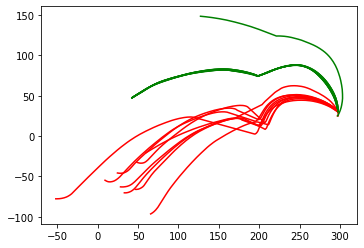

In [68]:
for rn in baseline_df.run.unique():
    graph_df = baseline_df[baseline_df['run'] == rn]
    if (graph_df.navx_poseX.min() > -100 and graph_df.navx_poseY.min() > -100 and graph_df.navx_poseY.max() < 200):
        plt.plot(graph_df['navx_poseX'], graph_df['navx_poseY'], c='r')
        plt.plot(graph_df['pose X'], graph_df['pose Y'], c='g')
plt.gca().set_aspect(1)
plt.show()